In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
train = pd.read_csv('train.csv', index_col=0)

In [4]:
target = ['SalePrice']
key = ['PID'] 
numeric = ['GrLivArea','LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea',
           'BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
           'LowQualFinSF','GarageYrBlt','GarageArea','WoodDeckSF','OpenPorchSF',
           'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','YrSold'
          ] 
## Let's say you wanted to classify 'YearBuilt' (for example) as ordinal. From a math point of view,
## does it make any difference?
numeric_to_categorical = ['MSSubClass','MoSold']

## Had to remove 'MasVnrType','Electrical','RoofMatl', 'Exterior1st','Exterior2nd', 'Utilities'
## because they get dropped later and am running these categorical through
## OneHotEncoder
categorical = ['MSZoning','Street','Alley','LotShape','LandContour','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle',
               'RoofStyle','Foundation', 'BsmtFinType1','BsmtFinType2','Heating','GarageType',
               'GarageFinish','PavedDrive','MiscFeature','SaleType','SaleCondition',
               'BedroomAbvGr', 'CentralAir'
              ]
## Moved 'BedroomAbvGr' to categorical for one-hot encoding. Moved 'CentralAir' to categorical because
## although binary was currently encoded as Y/N.
    
cat_ordinal = [
               'OverallQual','OverallCond', # numeric?
               'ExterQual','ExterCond', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'BsmtQual','BsmtCond', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'BsmtExposure', # {'No':1,'Mn':2,'Av':3,'Gd':4}
               'HeatingQC', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'BsmtFullBath','BsmtHalfBath', # numeric?
               'FullBath','HalfBath', # numeric?
               'KitchenAbvGr', # numeric?
               'KitchenQual', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'TotRmsAbvGrd', # numeric?
               'Functional', # {'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,
                             #  'Mod':5,'Min2':6,'Min1':7,'Typ':8}
               'Fireplaces', # numeric?
               'FireplaceQu', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'GarageCars', # numeric?
               'GarageQual', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'GarageCond', # {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
               'PoolQC', # {'Fa':1,'TA':2,'Gd':3,'Ex':4}
               'Fence' #{'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
               ]

## train cleaning

In [5]:
# converting all similar mappings together
# most popular mapping

## There is some imputing hidden in the convert_cat_ordinal function.

cat_ordinal_features = [
    'GarageQual','GarageCond',
    'FireplaceQu',
    'KitchenQual',
    'ExterQual','ExterCond',
    'BsmtQual','BsmtCond',
    'HeatingQC'
    ]
cat_ordinal_dict = {'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# now just unique mappings
# BsmtExposure
cat_ordinal_features = [
    'BsmtExposure'
]
cat_ordinal_dict = {'No':1,'Mn':2,'Av':3,'Gd':4}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# Functional
cat_ordinal_features = [
    'Functional'
]
cat_ordinal_dict = {'Sal':1,'Sev':2,'Maj2':3,'Maj1':4,
                    'Mod':5,'Min2':6,'Min1':7,'Typ':8}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# PoolQC
cat_ordinal_features = [
    'PoolQC'
]
cat_ordinal_dict = {'Fa':1,'TA':2,'Gd':3,'Ex':4}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)
# Fence
cat_ordinal_features = [
    'Fence'
]
cat_ordinal_dict = {'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
train = helper.convert_cat_ordinal_vars_to_num(train,
                                               cat_ordinal_features,
                                               cat_ordinal_dict)

In [6]:
LotFrontage_dict = {'1Fam':0.7139, 'TwnhsE':0.5849, 'Twnhs':0.5227, 'Duplex':0.7725, '2fmCon':0.6922}

In [7]:
train.loc[train['LotFrontage'].isna(), 'LotFrontage'] = train.loc[train['LotFrontage'].isna(), :].apply(
    lambda x: LotFrontage_dict[x['BldgType']]*np.sqrt(x['LotArea']), axis=1
)

In [8]:
## Removed 'LotFrontage' from here. Imputed above. Added Electrical here because there was NA in test.
## Also 'RoofMatl' because of 'Roll' in test.
## Also 'Exterior1st', 'Exterior2nd'
# weirdest nas. lot frontage. probably worth removing
# not dealing with them out of expediance. 
drop_now_but_look_at_later = ['MasVnrArea','GarageYrBlt','MasVnrType', 'Electrical', 'RoofMatl', 
                              'Exterior1st', 'Exterior2nd', 'Utilities']
train.drop(drop_now_but_look_at_later, axis=1,inplace = True)

In [9]:
na_none_features = ['MiscFeature','Alley','BsmtFinType1','BsmtFinType2',
                   'GarageFinish','GarageType']
for na_none_feature in na_none_features:
    train[na_none_feature] = train[na_none_feature].fillna(value = 'None')

In [10]:
## Think there was a typo here.
na_zero_features = ['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF']
for na_zero_feature in na_zero_features:
    train[na_zero_feature] = train[na_zero_feature].fillna(value = 0)

In [11]:
cols_na = train.loc[:,train.isna().any(axis=0)].columns.to_list()
cols_na

[]

In [12]:
nhds = train.loc[:,['Neighborhood', 'GrLivArea']]
nhds['LogSalePrice'] = np.log(train['SalePrice'])

In [13]:
nhds = nhds.groupby('Neighborhood').agg(
    Sqft_med=pd.NamedAgg('GrLivArea',np.median),
    LogPrice_med=pd.NamedAgg('LogSalePrice',np.median)
).fillna(0)

In [14]:
weights = train.groupby('Neighborhood').count().apply(lambda x: x['PID']/len(train) ,axis=1).to_list()

In [15]:
nhds.head()

,Sqft_med,LogPrice_med
Neighborhood,,
Blmngtn,1504.0,12.180755
Blueste,1118.0,11.727633
BrDale,1030.0,11.566466
BrkSide,1203.0,11.747998
ClearCr,1721.5,12.334845


In [16]:
scaler = StandardScaler()

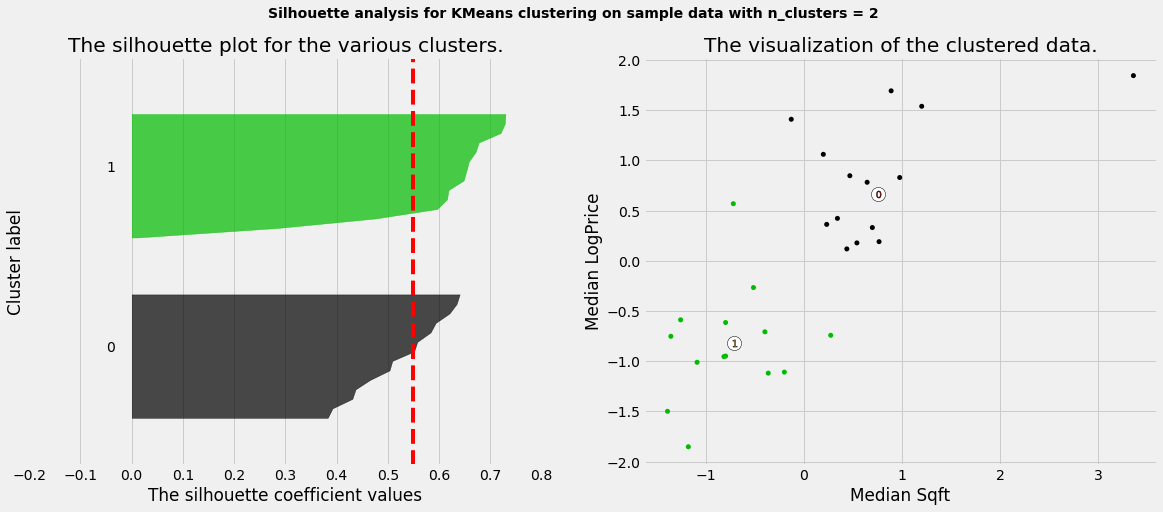

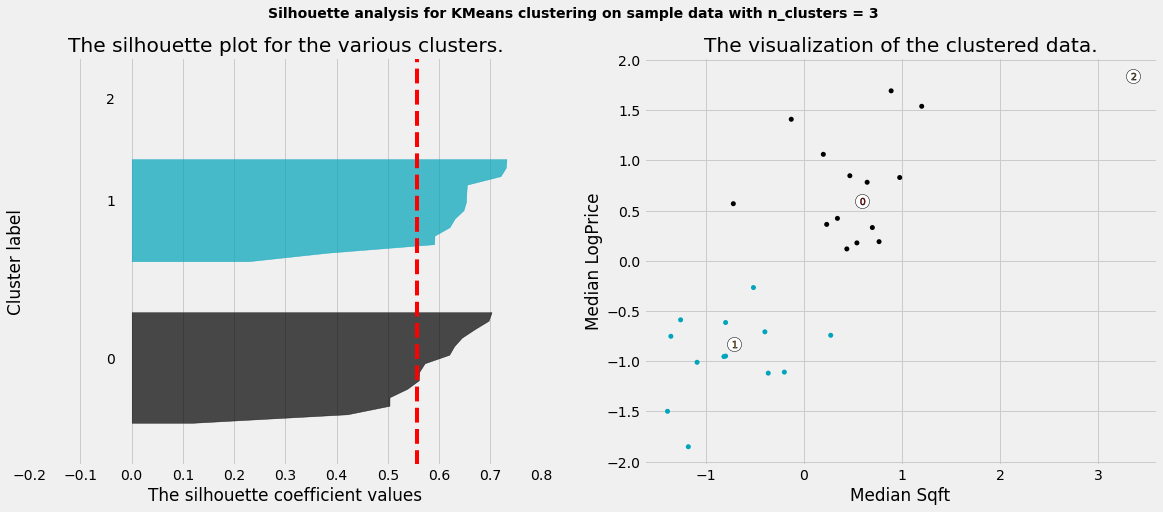

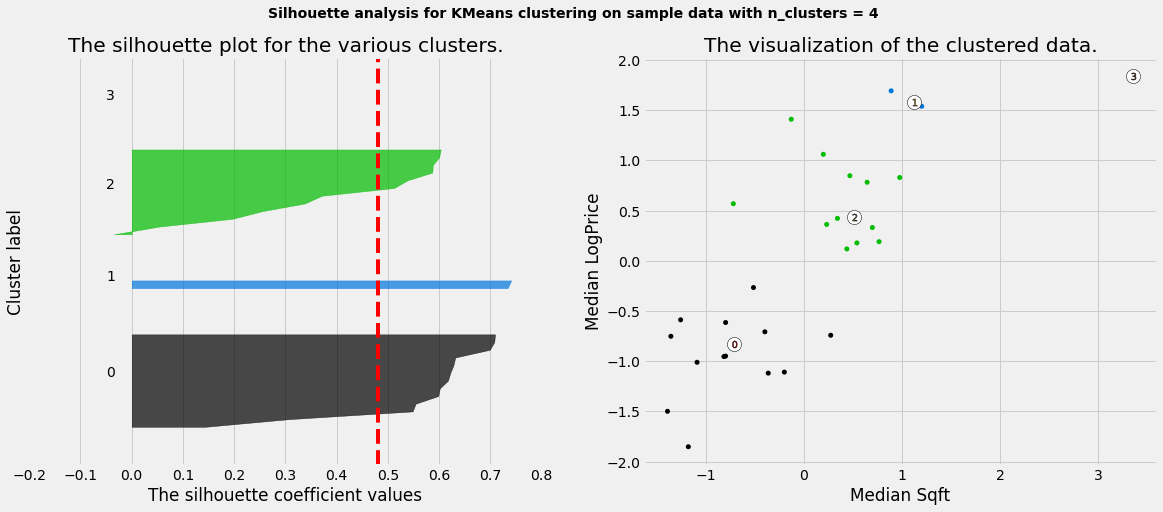

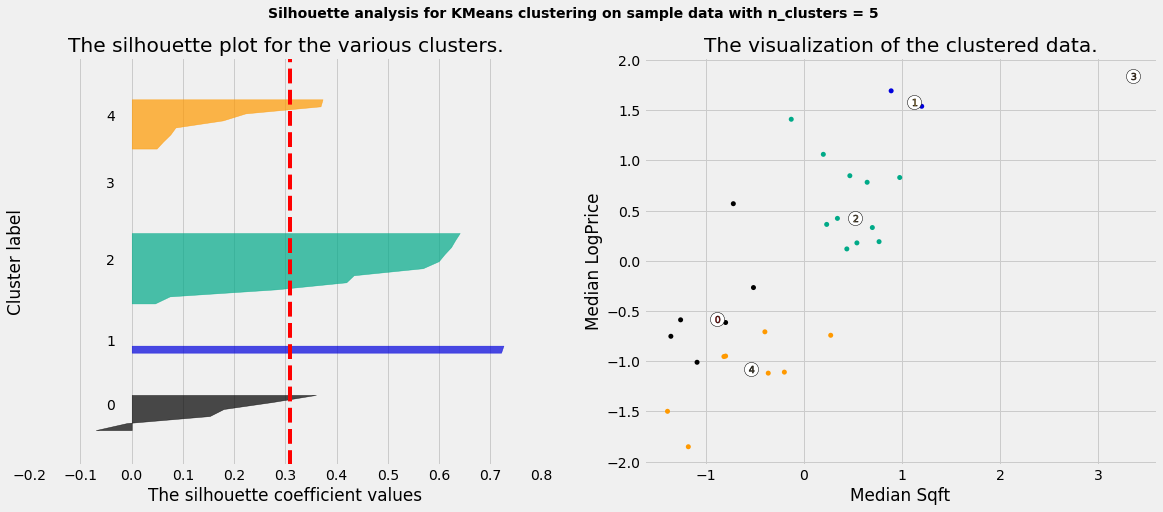

In [17]:
X = nhds
X = scaler.fit_transform(X)

inertias = []

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    ax1.set_xlim([-0.2, 0.8])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])

    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X, sample_weight=weights)
    
    inertias.append(clusterer.inertia_)
    
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    y_lower = 5
    
    for i in range(n_clusters):
        
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
    
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 5
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])
    ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                c=colors, edgecolor='k')

    centers = clusterer.cluster_centers_
    
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Median Sqft")
    ax2.set_ylabel("Median LogPrice")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
plt.show()

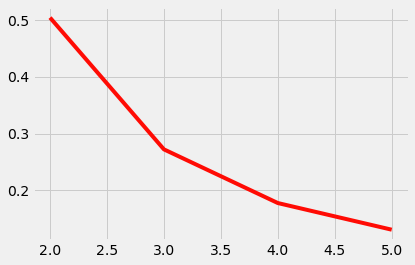

In [18]:
x = range_n_clusters
y = inertias
sns.lineplot(x=x,y=y)
plt.show()

In [19]:
clusterer = KMeans(n_clusters=3, random_state=42)
cluster_labels = clusterer.fit_predict(X)
nhds['Cluster'] = cluster_labels
nhds.sort_values('Cluster')

,Sqft_med,LogPrice_med,Cluster
Neighborhood,,,
Blmngtn,1504.0,12.180755,0
StoneBr,1696.0,12.619755,0
Somerst,1573.0,12.340759,0
SawyerW,1564.0,12.100156,0
NridgHt,1787.0,12.568940,0
NWAmes,1660.0,12.124048,0
Timber,1624.5,12.319242,0
GrnHill,1398.5,12.526341,0
Greens,1226.0,12.248806,0


In [20]:
cluster_dict = pd.DataFrame(data = {'Nhd_cluster':nhds.Cluster}, index=nhds.index).to_dict()['Nhd_cluster']

In [21]:
train['NhdCluster'] = train.apply(lambda x: cluster_dict[x['Neighborhood']], axis=1)

In [22]:
reg = LinearRegression()

In [23]:
# simple linear regression on 'GrLivArea'
X = train[['GrLivArea']]
y = np.log(train['SalePrice'])
reg.fit(X,y)
reg.score(X,y)

0.5361242929283243

In [24]:
# simple linear regression on log('GrLivArea')
X = np.log(train[['GrLivArea']])
y = np.log(train['SalePrice'])
reg.fit(X,y)
reg.score(X,y)

0.5554553624005024

In [25]:
def flatten(t):
    return [item for sublist in t for item in sublist]

In [26]:
# multilevel model, a simple linear regression on 'GrLiveArea' for each cluster
predictions = []
labels = []
for j in range(3):
    X = np.array(train.loc[train['NhdCluster']==j, 'GrLivArea']).reshape(-1,1)
    y = np.log(np.array(train.loc[train['NhdCluster']==j, 'SalePrice']))
    reg.fit(X,y) 
    predictions.append(list(reg.predict(X)))
    labels.append(list(y))
predictions = flatten(predictions)
labels = flatten(labels)
p_ = np.array(predictions)
l_ = np.array(labels)
RSS = np.sum((l_ - p_)**2)
TSS = np.sum((l_ - np.mean(l_))**2)
R2 = 1 - RSS/TSS
R2

0.6871166657906703

In [27]:
# multilevel model, a simple linear regression on log('GrLiveArea') for each cluster
predictions = []
labels = []
for j in range(3):
    X = np.log(np.array(train.loc[train['NhdCluster']==j, 'GrLivArea'])).reshape(-1,1)
    y = np.log(np.array(train.loc[train['NhdCluster']==j, 'SalePrice']))
    reg.fit(X,y) 
    predictions.append(list(reg.predict(X)))
    labels.append(list(y))
predictions = flatten(predictions)
labels = flatten(labels)
p_ = np.array(predictions)
l_ = np.array(labels)
RSS = np.sum((l_ - p_)**2)
TSS = np.sum((l_ - np.mean(l_))**2)
R2 = 1 - RSS/TSS
R2

0.6996079646572271

In [28]:
# This should be run with X of form whatever features you are interested in and also 'NhdCluster',
# and y your labels ('LogSalePrice') and also 'NhdCluster'. Both should be supplied as dataframes with
# matching indices.

def multilev_cross_val(estimator_0, estimator_1, estimator_2, X, y, n_splits=5, test_size=0.25, random_state=42):
    
    train_scores = []
    test_scores = []
    
    estimator_dict = {'estimator_0':estimator_0, 'estimator_1':estimator_1, 'estimator_2':estimator_2}
    ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    
    for train_index, test_index in ss.split(X):
        
        train_predictions = []
        train_labels = []
        test_predictions = []
        test_labels = []
        
        X_train = X.iloc[train_index, :]
        y_train = y.iloc[train_index, :]
        X_test = X.iloc[test_index, :]
        y_test = y.iloc[test_index, :]
        
        for j in range(3):
                        
            X_train_levj = pd.DataFrame(X_train.loc[X_train['NhdCluster']==j, :].drop('NhdCluster', axis=1))
            y_train_levj = y_train.loc[y_train['NhdCluster']==j, :].drop('NhdCluster', axis=1)
            X_test_levj = pd.DataFrame(X_test.loc[X_test['NhdCluster']==j, :].drop('NhdCluster', axis=1))
            y_test_levj = y_test.loc[y_test['NhdCluster']==j, :].drop('NhdCluster', axis=1)
            
            if len(X.columns) == 1:
                X_train_levj = np.array(X_train_levj).reshape(-1,1)
                X_test_levj = np.array(X_test_levj).reshape(-1,1)
            
            X_train_levj = np.array(X_train_levj)
            y_train_levj = np.array(y_train_levj)
            X_test_levj = np.array(X_test_levj)
            y_test_levj = np.array(y_test_levj)
            
            X_train_levj = scaler.fit_transform(X_train_levj)
            X_test_levj = scaler.transform(X_test_levj)
            
            estimator = estimator_dict[f'estimator_{j}']
            
            estimator.fit(X_train_levj, y_train_levj)
            
            train_predictions.append(list(estimator.predict(X_train_levj)))
            train_labels.append(list(y_train_levj))
            
            test_predictions.append(list(estimator.predict(X_test_levj)))
            test_labels.append(list(y_test_levj))
            
        train_predictions = flatten(train_predictions)
        train_labels = flatten(train_labels)
        p_train = np.array(train_predictions)
        l_train = np.array(train_labels)
        RSS_train = np.sum((l_train - p_train)**2)
        TSS_train = np.sum((l_train - np.mean(l_train))**2)
        
        train_scores.append(1 - RSS_train/TSS_train)
        
        test_predictions = flatten(test_predictions)
        test_labels = flatten(test_labels)
        p_test = np.array(test_predictions)
        l_test = np.array(test_labels)
        RSS_test = np.sum((l_test - p_test)**2)
        TSS_test = np.sum((l_test - np.mean(l_test))**2)
        
        test_scores.append(1 - RSS_test/TSS_test)
        
    return train_scores, test_scores

In [29]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)
scores = multilev_cross_val(reg, reg, reg, X, y)
print(scores[0])
print(scores[1])
print(np.mean(scores[0]))
print(np.mean(scores[1]))

[0.6950421201487633, 0.6906561459057801, 0.6899069372616786, 0.6842874595192583, 0.6951606617859138]
[0.6604917945027795, 0.6748368050131136, 0.6748915952202905, 0.6927279093230427, 0.6599662788072052]
0.6910106649242789
0.6725828765732863


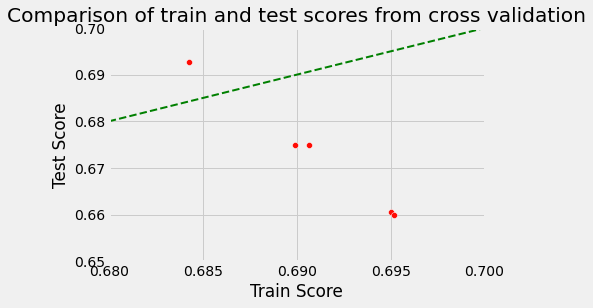

In [30]:
x = scores[0]
y = scores[1]
_ = sns.scatterplot(x=x,y=y)
_.set_xlim(.68,.7)
_.set_ylim(.65,.7)
_.set_xlabel('Train Score')
_.set_ylabel('Test Score')
_.set_xticks([.68, .685, .69, .695, .7])
_.plot([0.68,0.7],[0.68,0.7],'g--', linewidth=2)
_.set_title('Comparison of train and test scores from cross validation')
plt.show()

In [31]:
def multilev_ridgesearch(X, y, param_list=[0.1, 1, 10], method='max_test'):
    
    if method == 'max_test':
        
        max_test = 0

        for param0 in param_list:
            for param1 in param_list:
                for param2 in param_list:

                    estimator_0 = Ridge(alpha=param0)
                    estimator_1 = Ridge(alpha=param1)
                    estimator_2 = Ridge(alpha=param2)

                    train_scores, test_scores = multilev_cross_val(estimator_0, estimator_1, estimator_2, X, y)

                    if np.mean(test_scores) > max_test:
                        max_test = np.mean(test_scores)
                        best_params = [param0, param1, param2]

        return best_params, max_test
                
    elif method == 'min_dist':
        
        min_dist = 1

        for param0 in param_list:
            for param1 in param_list:
                for param2 in param_list:

                    estimator_0 = Ridge(alpha=param0)
                    estimator_1 = Ridge(alpha=param1)
                    estimator_2 = Ridge(alpha=param2)

                    train_scores, test_scores = multilev_cross_val(estimator_0, estimator_1, estimator_2, X, y)

                    if np.mean(abs(np.array(test_scores) - np.array(train_scores))) < min_dist:
                        min_dist = np.mean(abs(np.array(test_scores) - np.array(train_scores)))
                        best_params = [param0, param1, param2]

        return best_params, min_dist
    
    else: 
        return 'You need to select a valid method.'

In [32]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

results = multilev_ridgesearch(X, y)
results

([10, 0.1, 1], 0.6727237833131477)

In [33]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

scores = multilev_cross_val(Ridge(alpha=10), Ridge(alpha=0.1), Ridge(alpha=1), X, y)

print(scores[0])
print(scores[1])
print(np.mean(scores[0]))
print(np.mean(scores[1]))
print(np.mean(abs(np.array(scores[1])-np.array(scores[0]))))

[0.6950059911253641, 0.690618540497711, 0.6898689966404518, 0.6842492948309278, 0.6951227126930483]
[0.6607287164012872, 0.6750683964120641, 0.6752098804621531, 0.6929397968731392, 0.6596721264170948]
0.6909731071575006
0.6727237833131477
0.02172552466123747


In [34]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

results = multilev_ridgesearch(X, y, method='min_dist')
results

([10, 10, 10], 0.021184208755096457)

In [35]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

scores = multilev_cross_val(Ridge(alpha=10), Ridge(alpha=10), Ridge(alpha=10), X, y)

print(scores[0])
print(scores[1])
print(np.mean(scores[0]))
print(np.mean(scores[1]))
print(np.mean(abs(np.array(scores[1])-np.array(scores[0]))))

[0.6947549889232956, 0.6902461784303076, 0.6894423164029347, 0.6839357515420552, 0.6946884410928071]
[0.6601723416379621, 0.6747755905995877, 0.67625136042389, 0.6919093197565167, 0.6599851566268844]
0.6906135352782801
0.6726187538089683
0.021184208755096457


In [36]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

results = multilev_ridgesearch(X, y, param_list=[10, 100, 1000], method='min_dist')
results

([10, 100, 1000], 0.01928073248646427)

In [37]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

scores = multilev_cross_val(Ridge(alpha=10), Ridge(alpha=100), Ridge(alpha=1000), X, y)

print(scores[0])
print(scores[1])
print(np.mean(scores[0]))
print(np.mean(scores[1]))
print(np.mean(abs(np.array(scores[1])-np.array(scores[0]))))

[0.6883828948976018, 0.6826336519619107, 0.6787996590496133, 0.6754150242458296, 0.684332862765587]
[0.6443940051421934, 0.6659919399761882, 0.6760416438204035, 0.68106312284795, 0.6569659159057268]
0.6819128185841085
0.6648913255384924
0.01928073248646427


In [38]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

results = multilev_ridgesearch(X, y, param_list=[10, 100, 1000, 10000], method='min_dist')
results

([10, 100, 10000], 0.019276193514928132)

In [39]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

scores = multilev_cross_val(Ridge(alpha=10), Ridge(alpha=100), Ridge(alpha=10000), X, y)

print(scores[0])
print(scores[1])
print(np.mean(scores[0]))
print(np.mean(scores[1]))
print(np.mean(abs(np.array(scores[1])-np.array(scores[0]))))

[0.6880067546883105, 0.682230725476036, 0.6781013779576368, 0.6748401470751002, 0.68366324109845]
[0.6433897045151639, 0.6653560979345138, 0.6758485795015966, 0.6806562679535271, 0.6568428705729453]
0.6813684492591067
0.6644187040955494
0.019276193514928132


In [40]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

results = multilev_ridgesearch(X, y, param_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000])
results

([10, 0.001, 1], 0.6727243367826035)

In [41]:
X = train.loc[:,['GrLivArea', 'NhdCluster']]
y = train.loc[:, ['SalePrice', 'NhdCluster']]
y['LogSalePrice'] = np.log(y['SalePrice'])
y = y.drop('SalePrice', axis=1)

results = multilev_ridgesearch(X, y, param_list = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10])
results

([10, 1e-05, 1], 0.6727243423005036)